## Imports

In [ ]:
import leafmap
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import rasterize
from rasterio.mask import mask
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import json
from shapely import wkt
import torch
from samgeo import SamGeo, SamGeo2, raster_to_vector, overlay_images

## Plotting Existing Masks

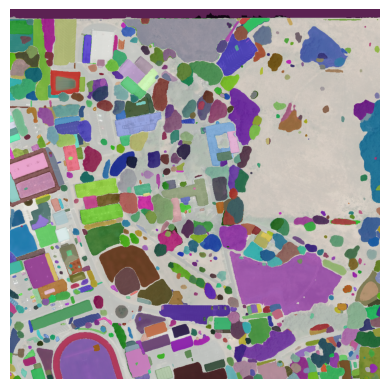

In [5]:
ann_img = rasterio.open("./annotations2.tif")
ann_img_data = ann_img.read([1,2,3])
ann_img_data = ann_img_data.transpose(1,2,0)

plt.imshow(ann_img_data)
plt.axis("off")
plt.show()

## SAM

In [ ]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 80,
}

sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=sam_kwargs,
)

In [ ]:
sam.generate("norm_img.tif", output="mask.tif", foreground=False)
raster_to_vector("mask.tif", output="mask.shp")
sam.show_masks(cmap="binary_r")
sam.show_anns(axis="off", opacity=1, output="annotation.tif")

## SAM2

In [ ]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    device="cuda",
    apply_postprocessing=False,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=4,
    crop_nms_thresh=0.8,
    crop_overlap_ratio=0.1,
    box_nms_thresh=0.9,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=0.1,
    use_m2m=True,
)

In [ ]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    device="mps",
    apply_postprocessing=False,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    crop_nms_thresh=0.8,
    crop_overlap_ratio=0.1,
    box_nms_thresh=0.9,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=5,
    use_m2m=True,
)

In [ ]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    apply_postprocessing=False,
    points_per_side=128,
    points_per_batch=64,
    pred_iou_thresh=0.85,
    stability_score_thresh=0.9,
    stability_score_offset=0.7,
    crop_n_layers=1,
    crop_nms_thresh=0.5,
    crop_overlap_ratio=0.1,
    box_nms_thresh=0.5,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=25,
    use_m2m=True,
)

In [ ]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    apply_postprocessing=False,
    points_per_side=128,
    points_per_batch=64,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.9,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=20,
    use_m2m=True,
)

In [ ]:
sam2.generate("norm_img.tif", output="masks4.tif")
raster_to_vector("masks4.tif", output="mask4.shp")
sam2.show_masks(cmap="jet")
sam2.show_anns(axis="off", alpha=0.6, output="annotations4.tif")

## Segmentation Masking

In [ ]:
def blacken_masked_regions(image_path, mask_gdf, output_path="masked_image.tif"):
    """
    Given a satellite image and a GeoDataFrame of polygon masks,
    blackens the masked regions in all bands and saves the result.

    Parameters:
        image_path (str): Path to the input image (GeoTIFF).
        mask_gdf (GeoDataFrame): Polygons representing existing masks.
        output_path (str): Path to save the new masked image.

    Returns:
        str: Path to the saved masked image.
    """
    with rasterio.open(image_path) as src:
        image = src.read()  # (bands, height, width)
        transform = src.transform
        meta = src.meta.copy()
        height, width = src.height, src.width

    # Rasterize mask_gdf to match image shape
    mask_raster = rasterize(
        [(geom, 1) for geom in mask_gdf.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    # Apply black mask across all bands
    masked_image = image.copy()
    for i in range(masked_image.shape[0]):
        masked_image[i][mask_raster == 1] = 0

    # Save new masked image
    meta.update({
        'dtype': masked_image.dtype,
        'count': masked_image.shape[0]
    })

    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(masked_image)

    print(f"Masked image saved to: {output_path}")
    return output_path


In [ ]:
gdf = gpd.read_file("./Temporary_Data/mask3.shp")
print(gdf.head())

image_path = "norm_img.tif"
image_src = rasterio.open(image_path)

In [ ]:
blacken_masked_regions("norm_img.tif", gdf, output_path="masked_image.tif")

In [ ]:
with rasterio.open("masked_image.tif") as src:
    img = src.read([1, 2, 3])  # Read RGB bands
    img = img.transpose(1, 2, 0)  # Transpose to
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Masked Image")
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
show(image_src, ax=ax)
gdf.boundary.plot(ax=ax, edgecolor="red")
plt.show()